# About this notebook

This notebook calculates a spectrum for a single photon energy

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Multiprocessing
import multiprocessing as mp
from multiprocessing import Pool

# For the progress bar
from ipywidgets import IntProgress
from IPython.display import display

# This package
import XNLdyn

%matplotlib notebook

In [7]:

pulse_energy_max = 15e-8 # Joule

N_local_fluences_to_calculate = 20
N_pulse_energies = 10

Nsteps_r = 100

pulse_profile_sigma= 400 # nm rms



## Set up the problem and modify the parameters a little
PAR = XNLdyn.XNLpars()
PAR.N_photens = 1
PAR.t0_i       = [0,]   # Arrival time on time-axis / fs
PAR.tdur_sig_i = [10,]  # Rms pulse duration / fs
PAR.E_i_abs    = [848.588888888889,] # Photon Energies of incident pulses / eV
PAR.lambda_res_Ei = (58.593287278409086,)
PAR.pendepth_nonres = (150,)


PAR.I0_i =  [XNLdyn.photons_per_J(PAR.E_i_abs[0])*pulse_energy_max]

#* XNLdyn.photons_per_J(PAR.E_i_abs[0])




In [11]:
pulse_energy_max_photons = pulse_energy_max *  XNLdyn.photons_per_J(PAR.E_i_abs[0])
pulse_energy_max_photons/PAR.atomic_density

12070835.42120716

In [12]:
sim = XNLdyn.XNLsim(PAR, DEBUG=True, load_tables = False)
PAR.FermiSolver.plot_lookup_tables()

UnboundLocalError: local variable 'fermis' referenced before assignment

<IPython.core.display.Javascript object>


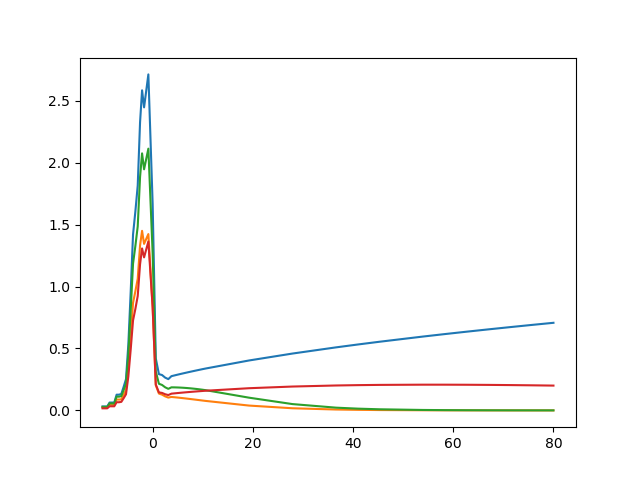

In [10]:
plt.figure()
plt.plot(PAR.E_j,PAR.m_j/PAR.enax_dE_j)
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e5,0)*PAR.m_j/PAR.enax_dE_j)
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e5,10)*PAR.m_j/PAR.enax_dE_j)
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e6,0)*PAR.m_j/PAR.enax_dE_j)

## Run a simulation for a single Fluence

In [14]:
%%time
fluences_joules_nm2, dA = XNLdyn.calculate_fluences(Nsteps_r, pulse_energy_max, pulse_profile_sigma) 
# These are just to get an idea where to calculate Fluences

fluences_simulated = np.logspace(np.log10(np.min(fluences_joules_nm2)),
                                 np.log10(np.max(fluences_joules_nm2)),
                                 N_local_fluences_to_calculate)


CPU times: user 737 µs, sys: 65 µs, total: 802 µs
Wall time: 267 µs


Simulating for  1.2874087823339324 photons per atom
Initializing a simulation where ['I0_i'] are changed to [6894.623054202759]

Starting to generate lookup tables for T between 296.0 to 100000295.0 and mu_chem between -79.4 and 79.4
Lookup tables generated.


<IPython.core.display.Javascript object>


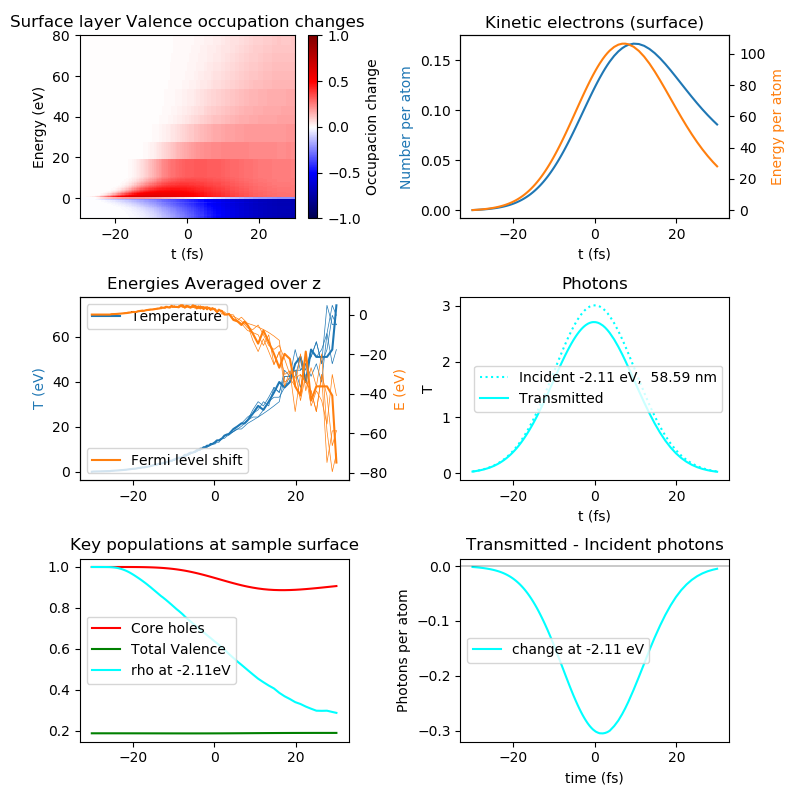

Transmission:  [90.08134251]  %
CPU times: user 2min 45s, sys: 358 ms, total: 2min 46s
Wall time: 2min 45s


(array([75.2427694]), array([67.77969682]))

In [15]:
%%time

print('Simulating for ', 1.0*np.max(fluences_joules_nm2)* XNLdyn.photons_per_J(PAR.E_i_abs[0])/(PAR.atomic_density*PAR.lambda_res_Ei[0]) ,'photons per atom')

XNLdyn.run_modified_simulation(PAR, dict(t_span=[-30, 30],method='RK45', rtol=1e-3, atol=1e-8, plot = True),
                               ['I0_i',] , [1.0*np.max(fluences_joules_nm2)* XNLdyn.photons_per_J(PAR.E_i_abs[0]),])

# Load a spectrum to simulate

<IPython.core.display.Javascript object>


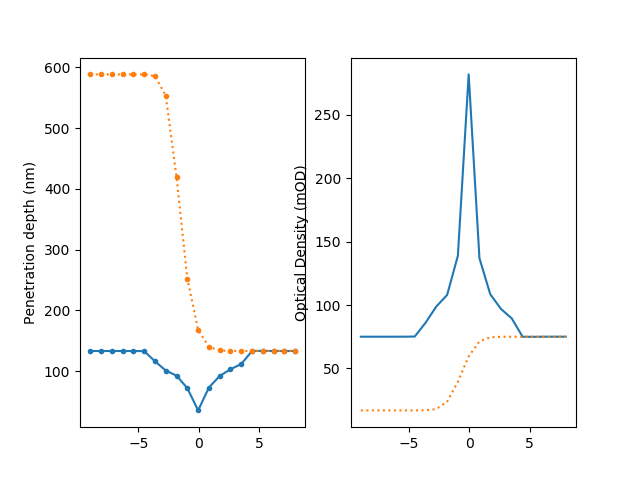

Text(0, 0.5, 'Optical Density (mOD)')

In [148]:
N_points_E = 20# 23
E_fermi = 850.7
Erange = 6
E_min, E_max = E_fermi-1.5*Erange, E_fermi+Erange
enax_abs = np.linspace(E_min, E_max+2, N_points_E) # Absolute energy axis to sample
enax_rel = enax_abs-E_fermi # Rélative energy axis to Fermi Energy, i.e. detuning

ld = np.load('../../Penetration_depth_deconvolved_spectrum.npz', allow_pickle=True)
pendepths = np.interp(enax_abs, ld['enax'],ld['spectrum'])
pendepths[enax_rel<0] = np.interp((E_fermi-enax_abs[enax_rel<0]), ld['enax']-E_fermi,ld['spectrum'])

ld = np.load('../../Penetration_depth_deconvolved_background.npz', allow_pickle=True)
pendepths_nonres = np.interp(enax_abs, ld['enax'],ld['spectrum'])
#pendepths_nonres[enax_rel<0] = np.interp((E_fermi-enax_abs[enax_rel<0]), ld['enax']-E_fermi,ld['spectrum'])

plt.figure()
plt.subplot(1,2,1)
plt.plot(enax_rel, pendepths,'.-')
plt.plot(enax_rel, pendepths_nonres,'.:')
plt.ylabel('Penetration depth (nm)')

plt.subplot(1,2,2)
plt.plot(enax_rel, 1e3*(10/pendepths),c='C0')
plt.plot(enax_rel, 1e3*(10/pendepths_nonres),c='C1',ls=':')
plt.ylabel('Optical Density (mOD)')


## Run it for all the fluences in the spot

TODO: Find solution for low temperature error
      and high temperature Error
TODO: Properly integrate FEG model following PHYSICAL REVIEW E 102, 063204 (2020)

In [129]:
sim_options = dict(t_span=[-35, 35],method='RK45', rtol=1e-3, atol=1e-8, plot = False)

In [149]:
%%time
print(f'I will run {N_points_E*N_local_fluences_to_calculate:.0f} Simualtions')

timeout = 300

progressbar = IntProgress(min=0, max=N_points_E*N_local_fluences_to_calculate) # instantiate the bar
display(progressbar) # display the bar

try:
    mp.set_start_method('fork')  # 'spawn' on windows, "fork" or "forkserver" on unix machines
except RuntimeError:
    pass
with Pool(processes=50) as pool:
    tasklist = {}
    for photon_energy, pendepdth, pendepth_nonres in zip(enax_abs, pendepths, pendepths_nonres):
        for fluence in fluences_simulated:
            #progressbar.value += 1
            fluence_photons = fluence* XNLdyn.photons_per_J(photon_energy)
            tasklist[(photon_energy,fluence)]=\
                pool.apply_async(XNLdyn.run_modified_simulation,(*(PAR, sim_options,
                                            ['I0_i','E_i_abs', 'lambda_res_Ei','lambda_nonres'] ,
                                            [(fluence_photons,),(photon_energy,),(pendepdth,),pendepth_nonres]),)
                                             )


    resultdict = {}
    for key in tasklist:
        resultdict[key] = tasklist[key].get(timeout=timeout)
        progressbar.value += 1


I will run 400 Simualtions


IntProgress(value=0, max=400)

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.01741495589398524,), (841.7,), (133.25546500924315,), 588.5143979189709]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.03298358839279645,), (841.7,), (133.25546500924315,), 588.5143979189709]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.06247027611716027,), (841.7,), (133.25546500924315,), 588.5143979189709]

Loaded lookup table successfully.
Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.11831749025241048,), (841.7,), (133.25546500924315,), 588.5143979189709]

Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.22409102968225533,), (841.7,), (133.25546500924315,), 588.5143979189709]

Ini


Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1710.8832867775366,), (842.5947368421054,), (133.25546500924315,), 588.5143979189709]

Loaded lookup table successfully.
Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(3240.3797323813556,), (842.5947368421054,), (133.25546500924315,), 588.5143979189709]

Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.017378009842782184,), (843.4894736842106,), (133.25546500924315,), 588.5143979189709]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.032913613289038565,), (843.4894736842106,), (133.25546500924315,), 588.5143979189709]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed t


Loaded lookup table successfully.
Transmission:  [98.31480119]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(36.98672533665483,), (844.3842105263159,), (133.25546500924315,), 588.5143946561411]

Loaded lookup table successfully.
Transmission:  [98.31483691]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(70.05213977733877,), (844.3842105263159,), (133.25546500924315,), 588.5143946561411]

Loaded lookup table successfully.
Transmission:  [98.31483685]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(132.6773928407374,), (844.3842105263159,), (133.25546500924315,), 588.5143946561411]

Loaded lookup table successfully.
Transmission:  [98.31483678]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(251.28840642080988,), (844.3842105263159,), (133.25546500924315,)

Transmission:  [98.28626356]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.22290626995748863,), (846.1736842105264,), (133.04181090660427,), 588.4159527999825]

Loaded lookup table successfully.
Transmission:  [98.31436365]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.42218014809849086,), (846.1736842105264,), (133.04181090660427,), 588.4159527999825]

Loaded lookup table successfully.
Transmission:  [98.31387474]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.7996010048638673,), (846.1736842105264,), (133.04181090660427,), 588.4159527999825]

Loaded lookup table successfully.
!!
!!
Transmission:  [98.31460572]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1.5144287808391905,), (846.1736842105264,), (133.04181090660427,), 588.4159527999825]

Lo

Transmission:  [98.31355375]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(474.4272083063454,), (847.0684210526316,), (116.30409713415712,), 585.7398593329357]

Loaded lookup table successfully.
Transmission:  [98.31483249]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(898.5559226437467,), (847.0684210526316,), (116.30409713415712,), 585.7398593329357]

Loaded lookup table successfully.
Transmission:  [98.31472932]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1701.8474741372797,), (847.0684210526316,), (116.30409713415712,), 585.7398593329357]

Loaded lookup table successfully.
Transmission:  [98.16128342]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(3223.266078649761,), (847.0684210526316,), (116.30409713415712,), 585.7398593329357]

Loaded lookup

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(2.8592287395327634,), (848.8578947368421,), (92.71415262630384,), 419.30905983667753]

Loaded lookup table successfully.
Transmission:  [98.23165069]  %
Transmission:  [98.30569707]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(5.41532372747353,), (848.8578947368421,), (92.71415262630384,), 419.30905983667753]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(10.256518014060642,), (848.8578947368421,), (92.71415262630384,), 419.30905983667753]

Loaded lookup table successfully.
Transmission:  [98.30085638]  %
Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(19.42564601245532,), (848.8578947368421,), (92.71415262630384,), 419.30905983667753]

Loaded lookup table successfully.
Transmissio


Energy -0.05 too close to others to satisfy the resonant bandwidth of 0.40
Loaded lookup table successfully.
Transmission:  [98.20888939]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.03263665695192632,), (850.6473684210526,), (35.5049162351083,), 167.94382522871635]

Energy -0.05 too close to others to satisfy the resonant bandwidth of 0.40
Loaded lookup table successfully.
Transmission:  [97.61084599]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.061813194703010235,), (850.6473684210526,), (35.5049162351083,), 167.94382522871635]

Energy -0.05 too close to others to satisfy the resonant bandwidth of 0.40
Loaded lookup table successfully.
Transmission:  [98.13191208]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.11707299080970063,), (850.6473684210526,), (35.5049162351083,), 167.94382522871635]

Energ

Transmission:  [97.64277975]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(1.504881288942409,), (851.542105263158,), (73.08743084859348,), 140.2018232603181]

Loaded lookup table successfully.
!!
!!
!!
!!
!!
Transmission:  [97.64278055]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(2.850215947525929,), (851.542105263158,), (73.08743084859348,), 140.2018232603181]

Loaded lookup table successfully.
!!
!!
!!
!!
!!
Transmission:  [97.64278098]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(5.398253674374747,), (851.542105263158,), (73.08743084859348,), 140.2018232603181]

Loaded lookup table successfully.
!!
!!
Transmission:  [96.07711325]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(10.22418766486648,), (851.542105263158,), (73.08743084859348,), 140.20

Transmission:  [87.56902042]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(3202.9668041227224,), (852.4368421052632,), (92.14178205600558,), 134.11516029130695]

Loaded lookup table successfully.
Transmission:  [87.35571992]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.01717757638132768,), (853.3315789473685,), (103.24541989147511,), 133.3787029997351]

Loaded lookup table successfully.
!!
!!
!!
Transmission:  [87.90636125]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.032533996203988,), (853.3315789473685,), (103.24541989147511,), 133.3787029997351]

Loaded lookup table successfully.
!!
!!
Transmission:  [87.69593585]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(0.061618757239332037,), (853.3315789473685,), (103.24541989147511,), 133.378702999

!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [83.24101885]  %
Transmission:  [83.24106439]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(5.381290898739477,), (854.2263157894737,), (111.87984857896807,), 133.335868497124]

!!
Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(10.192060497105675,), (854.2263157894737,), (111.87984857896807,), 133.335868497124]

Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [83.2413


!!
Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [86.20878845]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(5.375660305023685,), (855.121052631579,), (133.29143764778607,), 133.33472388190705]
!!

Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [84.35211219]  %
!!
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(10.1813962619127,), (855.121052631579,), (133.29143764778607,), 133.33472388190705]

Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [85.38010123]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(19.283366872199267,), (855.121052631579,), (133.291437


Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [84.82929521]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(36.484148140009374,), (856.0157894736842,), (133.42973476189022,), 133.3347099885247]

!!
Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [84.8188486]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(69.10026832324657,), (856.0157894736842,), (133.42973476189022,), 133.3347099885247]

!!
!!
Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [84.81892318]  %
!!
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(130.8745667850324,), (856.0157894736842,), (133.42973476189022,), 133.3347099885247]



!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [86.04952142]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(5.36443439245093,), (856.9105263157895,), (133.25546500924315,), 133.33470992230002]

Loaded lookup table successfully.
!!
!!
Transmission:  [86.04974521]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(10.160134601424593,), (856.9105263157895,), (133.25546500924315,), 133.33470992230002]

!!
Loaded lookup table successfully.
!!

!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [86.05629976]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(19.223026118226024,), (857.8052631578947,), (133.25546500924315,), 133.33470992230002]

!!
Loaded lookup table successfully.
!!
!!
!!
!!
!!
Transmission:  [86.05658364]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(36.40803829807737,), (857.8052631578947,), (133.25546500924315,), 133.33470992230002]

!!
Loaded lookup table successfully.
!!
Transmission:  [86.11180999]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(68.95611776012095,), (857.8052631578947,), (133.25546500924315,), 133.33470992230002]

!!
Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
Transmission:  [87.13999451]  %
Initializing a simulation where

!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [86.04756819]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(19.202996364313446,), (858.7,), (133.25546500924315,), 133.33470992230002]

!!
Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [86.04783457]  %
!!
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_nonres'] are changed to [(36.37010233299752,), (858.7,), (133.25546500924315,), 133.33470992230002]

!!
Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [86.04753506]  %
!!
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei', 'lambda_

!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [86.04760528]  %
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [86.04808685]  %
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [86.04756608]  %
!!
!!
!!
!!
Transmission:  [86.04754535]  %
!!
!!
!!
!!
!!
!!
!!
Transmission:  [86.04767968]  %
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [86.04782043]  %
Transmission:  [86.

## Assemble the results into a Matrix

In [152]:
fl_dep_spectrum_I = np.zeros((N_points_E,N_local_fluences_to_calculate))
fl_dep_spectrum_T = np.zeros((N_points_E,N_local_fluences_to_calculate))

for i_photen in range(N_points_E):
    for i_pulseen in range(N_local_fluences_to_calculate):
        fl_dep_spectrum_I[i_photen, i_pulseen], fl_dep_spectrum_T[i_photen, i_pulseen]  = \
            resultdict[(enax_abs[i_photen],fluences_simulated[i_pulseen])]


<IPython.core.display.Javascript object>


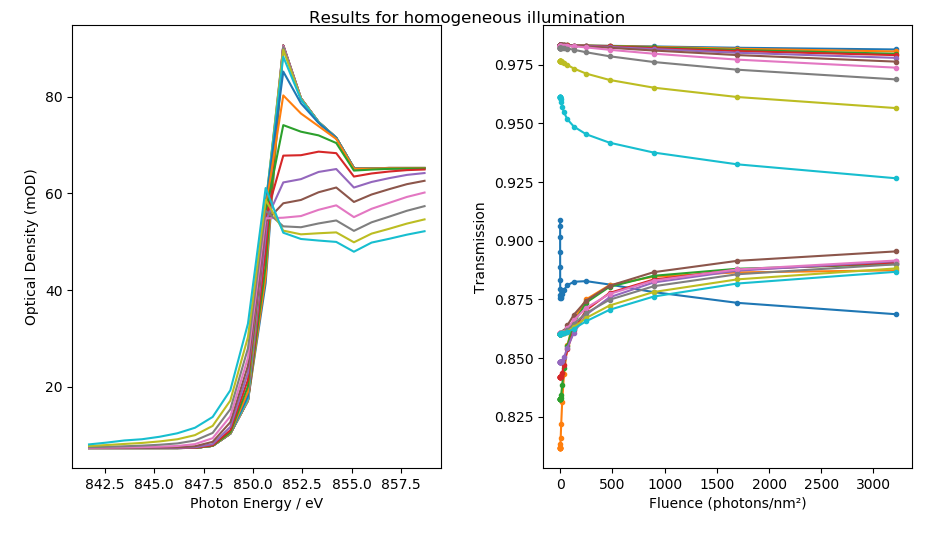

In [153]:
T = fl_dep_spectrum_T/fl_dep_spectrum_I

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
fig.suptitle('Results for homogeneous illumination')
ax1.plot(enax_abs,1e3*np.log10(1/T))
ax1.set_ylabel('Optical Density (mOD)')
ax1.set_xlabel('Photon Energy / eV')

plt.sca(ax2)
plt.plot(fluences_simulated*XNLdyn.photons_per_J(850), T[:,:].T, '.-')#, label ='For one z-stack'
plt.xlabel('Fluence (photons/nm²)')
plt.ylabel('Transmission')
#plt.xscale('log')
#plt.legend(loc = 'lower right')

plt.tight_layout()


<IPython.core.display.Javascript object>


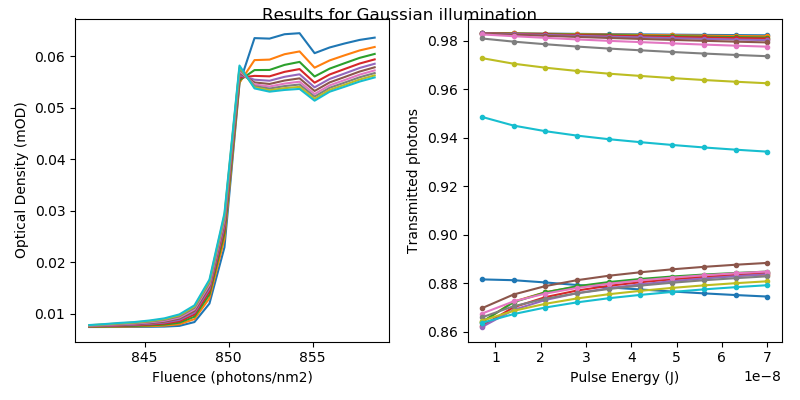

In [154]:
# These are the pulse energies for which we evaluate stuff
final_pulse_energies = np.linspace(1/N_pulse_energies, 1, N_pulse_energies)* pulse_energy_max

final_transmissions = np.zeros((N_points_E, N_pulse_energies))
final_incidence_check = np.zeros((N_points_E, N_pulse_energies))
for i_photen in range(N_points_E):

    for ipe, pulse_en in enumerate(final_pulse_energies*XNLdyn.photons_per_J(enax_abs[i_photen])):
        local_fluences, dA = XNLdyn.calculate_fluences(Nsteps_r, pulse_en, pulse_profile_sigma)
        
        
        local_transmitted = np.interp(local_fluences, fluences_simulated*XNLdyn.photons_per_J(enax_abs[i_photen]),
                                      fl_dep_spectrum_T[i_photen,:])# tr[:, 0]
        final_transmissions[i_photen,ipe] = np.sum(local_transmitted*dA)

        
        local_incidence_check = np.interp(local_fluences, fluences_simulated*XNLdyn.photons_per_J(enax_abs[i_photen]),
                                          fl_dep_spectrum_I[i_photen,:])

        final_incidence_check[i_photen,ipe] = np.sum(local_incidence_check*dA) # should result equal final_pulse_energies

        
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
fig.suptitle('Results for Gaussian illumination')

plt.sca(ax1)
plt.plot(enax_abs,np.log10(final_incidence_check/final_transmissions) )#, label ='For one z-stack'
plt.xlabel('Fluence (photons/nm2)')
plt.ylabel('Optical Density (mOD)')

plt.sca(ax2)
plt.plot(final_pulse_energies, (final_transmissions/final_incidence_check).T, '.-')

plt.xlabel('Pulse Energy (J)')
plt.ylabel('Transmitted photons')
#plt.legend(loc = 'lower left')
plt.tight_layout()

<IPython.core.display.Javascript object>


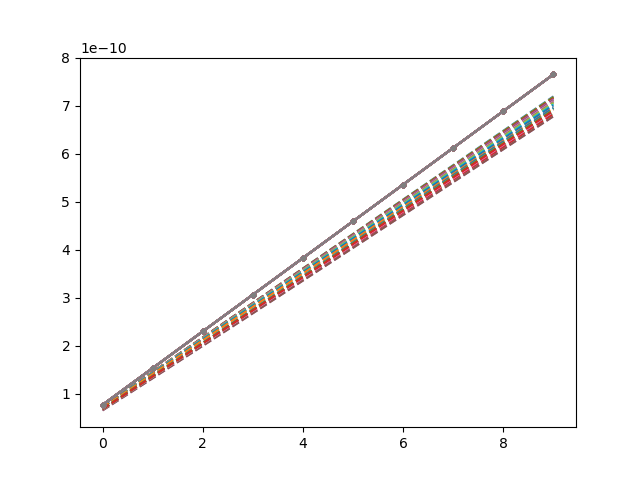

In [111]:
plt.figure()
plt.plot((1/XNLdyn.photons_per_J(enax_abs))*final_transmissions.T,'--')
plt.plot((1/XNLdyn.photons_per_J(enax_abs))*final_incidence_check.T,'.-')
#plt.plot(final_pulse_energies,'x')